
You can access the full analysis of the project in this [Github repository](https://github.com/Awoo56709/eds220-hw4)

# About

This blog presents two analyses of the Eaton and Palisades fires that occurred in Los Angeles County in January 2025. Using Landsat 8 false-color imagery, we visualize the impacts of the fires with infrared bands to identify burn severity and spatial boundaries.

The analysis also integrates the Environmental Justice Index (EJI) to examine the socioeconomic characteristics of communities within the fire perimeters.

Together, these complementary analyses combine environmental justice and geospatial perspectives, revealing both ecological impacts and social disparities.

# Highlights of the analysis

This project used several geospatial techniques. Key components include:

Geospatial Visualization Combining fire perimeter shapefiles with satellite data allows us to measure both physical impacts and social vulnerability in affected areas. These insights can inform future planning and adaptation strategies.

Environmental Justice Component By integrating California’s Environmental Justice Index (EJI) data, we used spatial joins and clipping to examine socioeconomic vulnerability in fire-affected communities.

Satellite Imagery and False Color False-color visualization using xarray and rioxarray processed Landsat 8 bands to highlight fire scars and vegetation health.

Layer Integration Combining multiple datasets (perimeters, imagery, socioeconomic data) provided a multifaceted view of wildfire impacts


# Dataset descriptions

Eaton and Palisades Fire Perimeter Data:

The Eaton and Palisades dissolved Fire Perimeter (2025) data published by Los Angeles County, provides shapefiles of dissolved polygons of the Eaton and Palisades fire perimeters. These files of which were daily perimeter snapshots, were merged to create a single fire perimeter for each fire. This dataset was from the NIFC FIRIS fire service and is hosted on ArcGIS Hub containing data for both fires. Date Accessed:11/24/2025

Landsat 8 Data: 

Landsat 8 Data NetCDF dataset containing atmospherically corrected reflectance data from Landsat 8 via the Microsoft Planetary Computer. Includes spectral bands (red, green, blue, near-infrared, shortwave infrared) clipped to the Eaton and Palisades fire perimeters. Spatial resolution: 30 meters. Accessed: 11/24/2025.

Environmental Justice Index (EJI) Data Census-tract level socioeconomic and demographic indicators estimating vulnerability, recovery potential, and mitigation capacity. Variables include population, housing, transportation, and socioeconomic status. Accessed: 11/24/2025.




## Analysis 1: False Color Visualization


## Setup and Data Import


In [3]:

# Import required libraries for geospatial analysis and visualization
import os
import numpy as np
import rioxarray as rio
import matplotlib.pyplot as plt
import geopandas as gpd
import xarray as xr

### Loading Fire Perimeter Data

Fire perimeters provide the spatial boundaries of interest for the analysis.


In [4]:
# Load fire perimeter shapefiles
eaton = gpd.read_file('data\eaton_fire\Eaton_Perimeter_20250121.shp')

# Load fire perimeter shapefiles
palisades = gpd.read_file('data\palisades_fire\Palisades_Perimeter_20250121.shp')

Both datasets contain polygon geometries for the fire perimeters, with length and area attributes. Both use the EPSG:3857 CRS (projected).

## Loading and Processing Landsat Imagery

The Landsat 8 data contains multiple spectral bands capturing different wavelengths of reflected light. Each band provides information about surface conditions.

In [5]:

# a,b Activate and Import netCDF4
import netCDF4
# c) Check activation and version
print(netCDF4.__version__)


1.7.3


In [6]:

# Generate variable for path
NC_fp = os.path.join('data','landsat8-2025-02-23-palisades-eaton.nc')

# Use netCDF4
landsat = xr.open_dataset("data/landsat8-2025-02-23-palisades-eaton.nc", engine="netcdf4")

In [7]:
# Explore dimensions and coordinates
print("Dimensions:", landsat.dims)
print("\nCoordinates:", list(landsat.coords))
print("\nData variables:", list(landsat.data_vars))

Dimensions: FrozenMappingWarningOnValuesAccess({'y': 1418, 'x': 2742})

Coordinates: ['y', 'x', 'time']

Data variables: ['red', 'green', 'blue', 'nir08', 'swir22', 'spatial_ref']


The Landsat dataset spans 1418 x 2742 pixels and contains five spectral bands: red, green, blue, nir08, swir22.

### Restoring Spatial Information

In [8]:

# Recover the geospatial information from spatial_ref
landsat = landsat.rio.write_crs(landsat.spatial_ref.crs_wkt)


The CRS metadata (spatial_ref) was restored to EPSG:32611, appropriate for Los Angeles County.

### Handling Missing Values

Clouded areas contained NaN values, which caused visualization errors. These were filled to allow rendering.

In [9]:
# Identify which bands have nan values using numpy.isnan()
nan_bands = []
for band in ['red', 'green', 'blue', 'nir08', 'swir22']:
    if np.isnan(landsat[band]).any():
        nan_bands.append(band)

print("Bands with NaN values:", nan_bands)

# Substitute any nan values for 0
landsat = landsat.fillna(0)

Bands with NaN values: ['green', 'blue']


### True Color Visualization

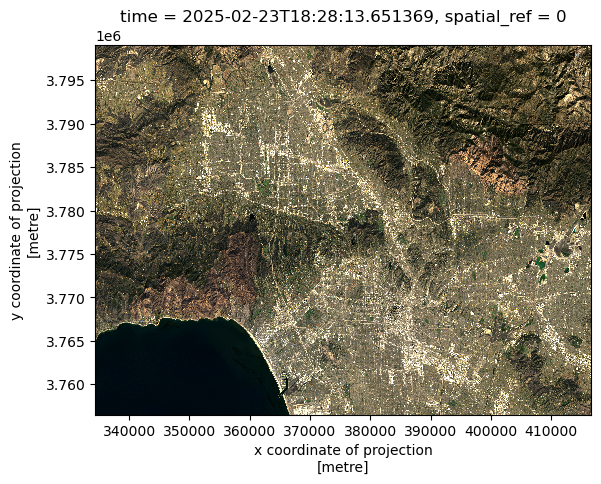

In [10]:
# Re-plot with the true color image
landsat[['red', 'green', 'blue']].to_array().plot.imshow(robust = True)
plt.show()

The robust=True parameter clips extreme outliers, preventing washed-out imagery.


### False Color Analysis

False color composites use non-visible wavelengths to reveal features that are not discernible to the human eye. By assigning short (SWIR) to red, near-infrared (NIR) to green, and red to blue, we create imagery where vegetation appears on the green scale and burned areas show a range of eddish-brown tones.

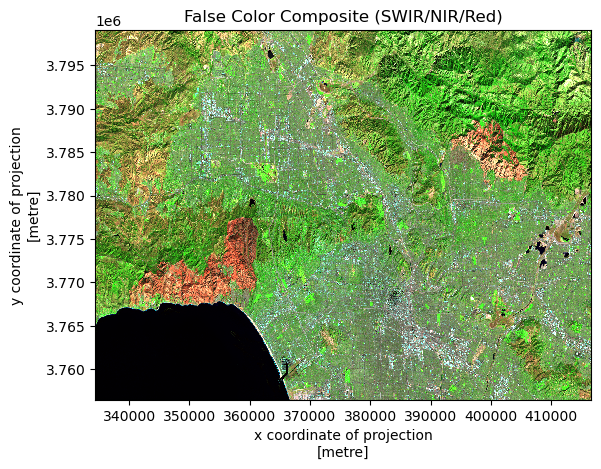

In [11]:
# Specify bands for false color composite
landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust = True)
plt.title('False Color Composite (SWIR/NIR/Red)')
plt.show()


The purpse of this band combination is to discern:

- **Healthy vegetation** which has high NIR reflectance and low SWIR reflectance and appears bright green
- **Burned areas** which have low NIR and moderate SWIR reflectance and appears reddish brown
- **Urban areas** which show moderate reflectance across all bands and appear in neutral colors

### Final Map

We overlay the fire perimeters onto our false color image. This requires reprojecting the vector data to match the raster's coordinate system (EPSG:32611).

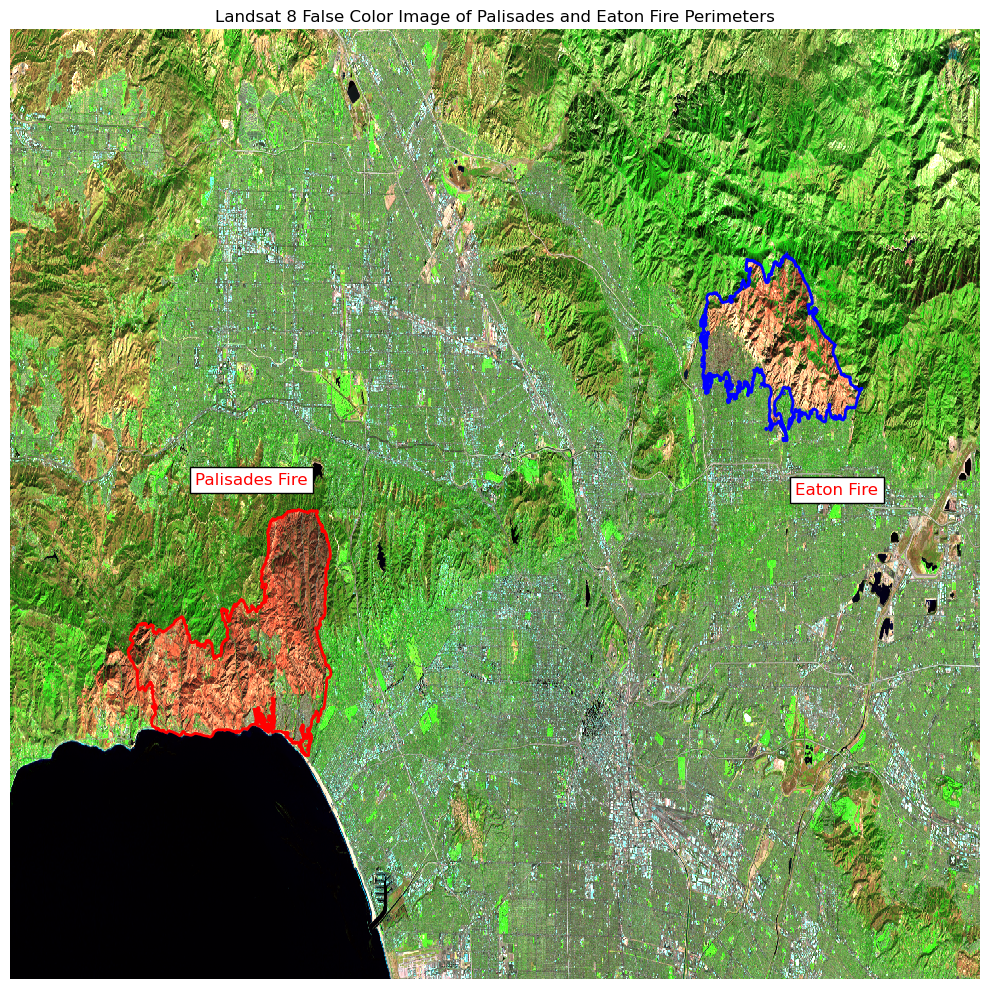

In [12]:
# Reproject fire perimeters to match Landsat CRS
eaton = eaton.to_crs(landsat.rio.crs)
palisades = palisades.to_crs(landsat.rio.crs)

# Create comprehensive map
fig, ax = plt.subplots(figsize=(10, 10))

# Plot false color composite
landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(
    ax=ax,
    robust=True,
    add_colorbar=False
)
# Add Palisades and Eaton fire perimeters
eaton.boundary.plot(ax=ax, edgecolor='blue', linewidth=2)
palisades.boundary.plot(ax=ax, edgecolor='red', linewidth=2)


# Add false color raster
landsat[["swir22", "nir08", "red"]].to_array().plot.imshow(robust=True)

# Add title
ax.set_title('Landsat 8 False Color Image of Palisades and Eaton Fire Perimeters')

# Add labels with gray background
plt.figtext(0.20, 0.51, "Palisades Fire", color='red', fontsize=12, bbox=dict(facecolor='white'))
plt.figtext(0.80, 0.50, "Eaton Fire", color='red', fontsize=12, bbox=dict(facecolor='white'))

# Remove axes
ax.axis('off')

# Display the map
plt.tight_layout()
plt.show()

The Eaton fire (overlaid in blue) and the Palisades fire (overlaid in red) outline the burn perimeter. This false color composite displays the Eaton and Palisades fire areas captured by Landsat 8 on February 23, 2025. The image uses **shortwave infrared (SWIR)**, **near-infrared (NIR)**, and **red** bands to highlight burn scars and vegetation health.

**Key features:**

- **Bright green areas**: Healthy vegetation (high NIR reflectance)
- **Reddish-brown areas**: Burned areas and bare soil (low NIR, moderate SWIR)
- **Urban/developed areas**: Neutral colors (moderate reflectance across bands)


## Analysis 2: Environmental Justice Dimensions

This analysis examines socioeconomic characteristics of communities impacted by the fires. While fires affect all habitats, they do not impact all communities equally.

We used the Environmental Justice Index (EJI) to identify socioeconomic vulnerability within fire perimeters.


In [14]:
# Read in the EJI dataset
ca_eji_fp = 'data/EJI_2024_California/EJI_2024_California.gdb'
ca_eji = gpd.read_file(ca_eji_fp)

In [15]:
# Reproject all datasets to the same crs
eaton = eaton.to_crs(ca_eji.crs)
palisades = palisades.to_crs(ca_eji.crs)


In [16]:
# Get the EJI tracts intersecting the eaton fire perimeter
eji_eaton_join = gpd.sjoin(ca_eji, eaton, how='inner', predicate='intersects')


C:\Users\joshu\AppData\Local\Temp\ipykernel_8144\1830484563.py:19: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


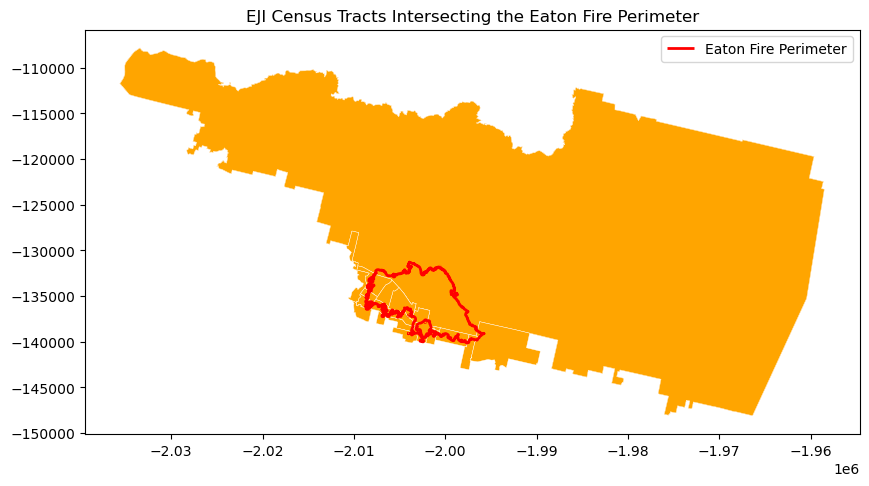

In [17]:
fig, ax = plt.subplots(figsize=(10, 10))

eji_eaton_join.plot(
    ax=ax, 
    color="orange", 
    edgecolor="white", 
    linewidth=0.3,
    label="Intersecting EJI Tracts"
)

eaton.boundary.plot(
    ax=ax,
    color="red",
    linewidth=2,
    label="Eaton Fire Perimeter"
)

ax.set_title("EJI Census Tracts Intersecting the Eaton Fire Perimeter")
ax.legend()
plt.show()

In [18]:
# Clip tracts to the palisades and eaton fire perimeters
eji_palisades_clip = gpd.clip(ca_eji, palisades)
eji_eaton_clip = gpd.clip(ca_eji, eaton)


In [19]:
# Get the EJI tracts intersecting the palisades fire perimeter
eji_palisades_join = gpd.sjoin(ca_eji, palisades, how='inner', predicate='intersects')

C:\Users\joshu\AppData\Local\Temp\ipykernel_8144\2799784687.py:15: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


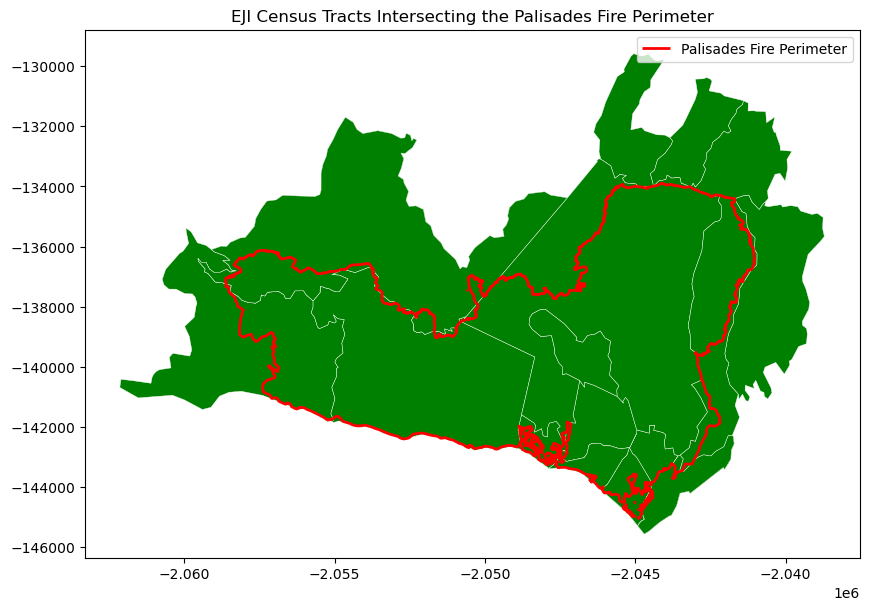

In [20]:

fig, ax = plt.subplots(figsize=(10, 10))

eji_palisades_join.plot(ax=ax, 
                        color="green", 
                        edgecolor="white", 
                        linewidth=0.3,
                        label="Intersecting EJI Tracts")

palisades.boundary.plot(ax=ax,
                         color="red",
                         linewidth=2,
                         label="Palisades Fire Perimeter")

ax.set_title("EJI Census Tracts Intersecting the Palisades Fire Perimeter")
ax.legend()
plt.show()


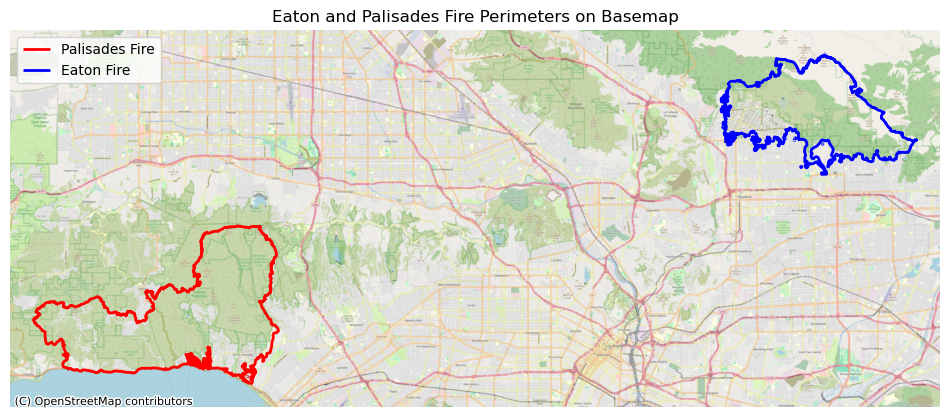

In [21]:

import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# Reproject to Web Mercator for basemap
palisades_3857 = palisades.to_crs(epsg=3857)
eaton_3857 = eaton.to_crs(epsg=3857)

# Get bounds from each fire
pminx, pminy, pmaxx, pmaxy = palisades_3857.total_bounds
eminx, eminy, emaxx, emaxy = eaton_3857.total_bounds

minx = min(pminx, eminx)
miny = min(pminy, eminy)
maxx = max(pmaxx, emaxx)
maxy = max(pmaxy, emaxy)

# Plot 
fig, ax = plt.subplots(figsize=(12, 10))

# Set zoom *before* adding basemap
buffer = 2000  # small padding around the fire
ax.set_xlim(minx - buffer, maxx + buffer)
ax.set_ylim(miny - buffer, maxy + buffer)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=13)

# Plot fire boundaries
palisades_3857.boundary.plot(ax=ax, color="red", linewidth=2, label="Palisades Fire")
eaton_3857.boundary.plot(ax=ax, color="blue", linewidth=2, label="Eaton Fire")

# Legend + title
ax.legend(loc = 'upper left')
ax.set_title("Eaton and Palisades Fire Perimeters on Basemap")
ax.axis("off")

plt.show()

We overlay the map of the Eaton and Palisades fire with the openstreetmap basemap for Los Angeles. 


C:\Users\joshu\AppData\Local\Temp\ipykernel_8144\3834148586.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


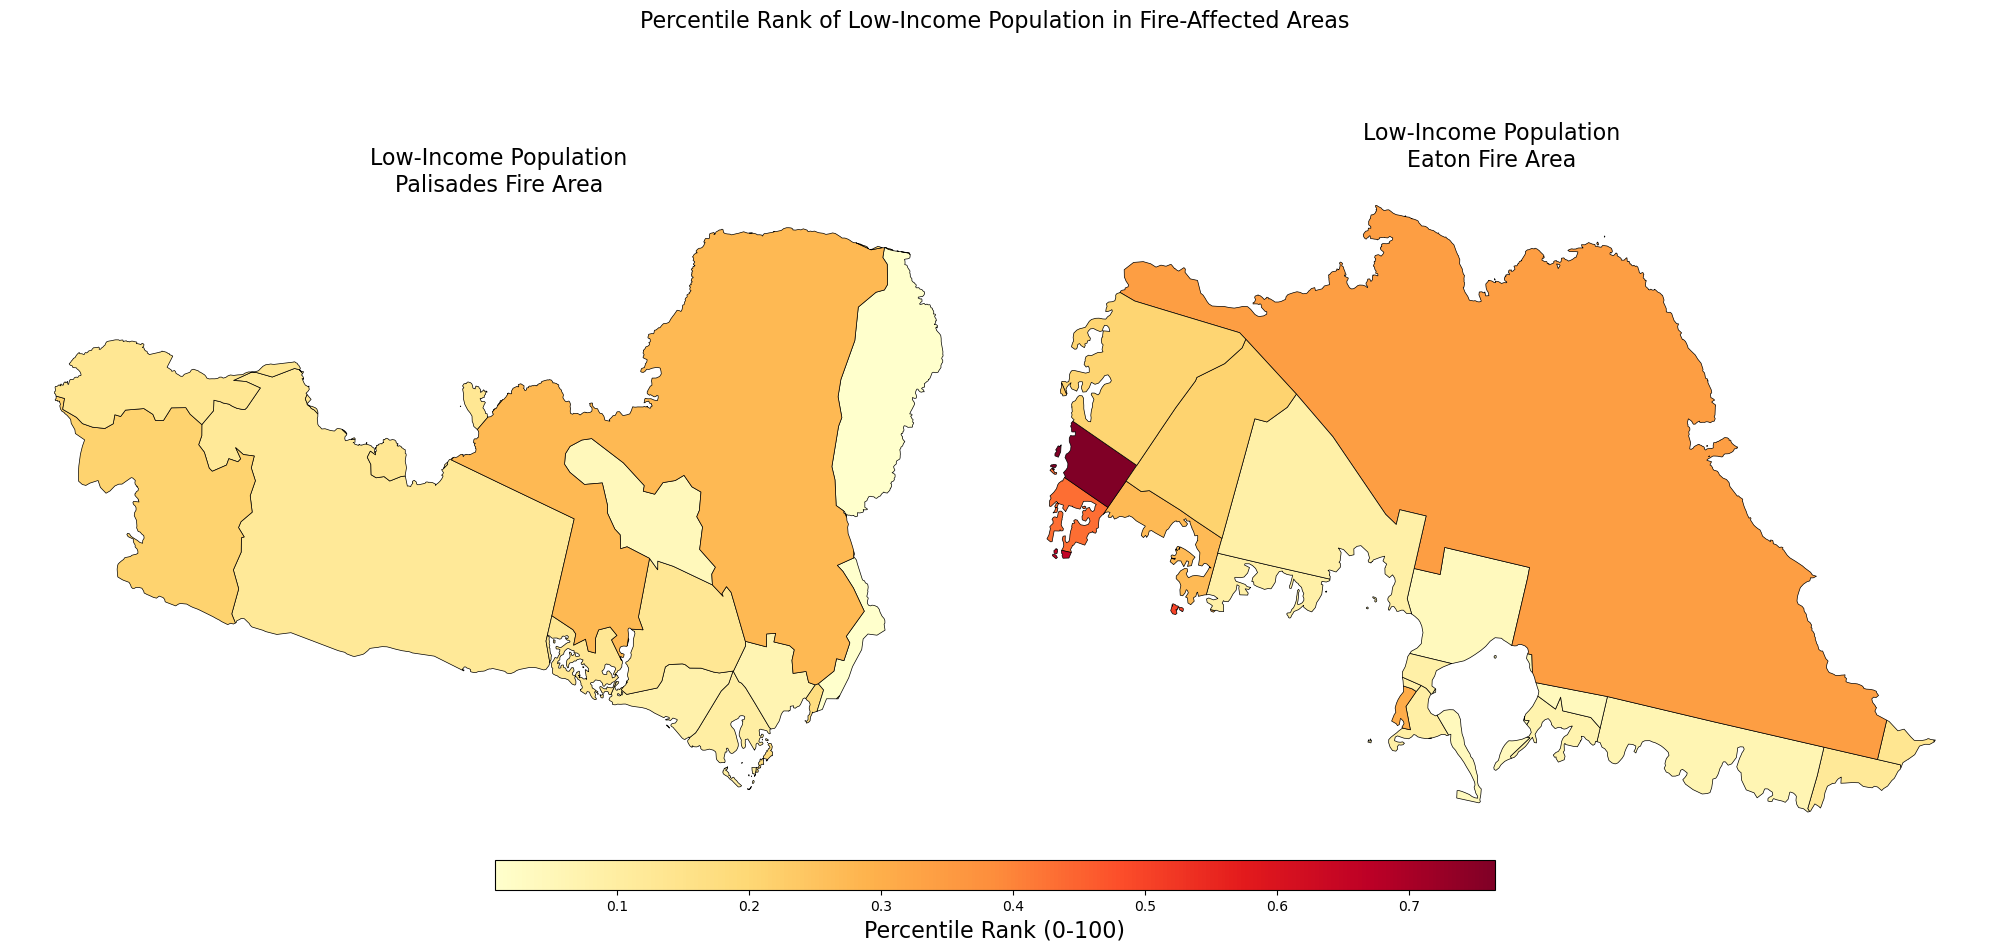

In [22]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Define common scale for comparison
eji_variable = 'EPL_POV200'
#eji_variable = 'E_AGE65'
vmin = min(eji_palisades_clip[eji_variable].min(),
           eji_eaton_clip[eji_variable].min())
vmax = max(eji_palisades_clip[eji_variable].max(),
           eji_eaton_clip[eji_variable].max())


# Eaton Plot

eji_eaton_clip.plot(
    column=eji_variable,
    vmin=vmin, vmax=vmax,
    cmap='YlOrRd',
    legend=False,
    ax=ax2,
    edgecolor='black',
    linewidth=0.5
)
ax2.set_title('Low-Income Population\nEaton Fire Area',
              fontsize=16)
ax2.axis('off')


# Palisades Plot

eji_palisades_clip.plot(
    column=eji_variable,
    vmin=vmin, vmax=vmax,
    cmap='YlOrRd',
    legend=False,
    ax=ax1,
    edgecolor='black',
    linewidth=0.5
)
ax1.set_title('Low-Income Population\nPalisades Fire Area',
              fontsize=16)
ax1.axis('off')

# Overall title
fig.suptitle('Percentile Rank of Low-Income Population in Fire-Affected Areas',
             fontsize=16)

# Shared colorbar
sm = plt.cm.ScalarMappable(
    cmap='YlOrRd',
    norm=plt.Normalize(vmin=vmin, vmax=vmax)
)
cbar_ax = fig.add_axes([0.25, 0.10, 0.5, 0.03])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Percentile Rank (0-100)', fontsize=16)

plt.tight_layout()
plt.show()

## Findings

This analysis reveals the socioeconmic vulnerability within each of the fire perimeters. The maps show percentile rankings of low-income population (households earning less than 200% of the federal poverty level) within census tracts. The higher percentile values (dark red) indicate greater economic vulnerability. 


**Eaton Fire Area:**

The burn area shows higher percentile rankings compared to the Palisades area, with large portions in the 50th-70th percentiles and some tracts reaching the 80th-90th percentiles (Altadena). On average, these darker areas demonstrate that fires disproportionately affected communities that are more socioeconomically vulnerable.

**Palisades Fire Area:**

The Palisades perimeter and its census tracts show predominantly low to moderate percentile rankings (roughly 10th-40th percentiles). This indicates that there was proportionaly less socioeconomically vulnerable communities affected by the Palisades fire.



**Environmental Justice Implications:**

These contrasting patterns reveal that while fires affect habitats, communities and individuals, those that are socioeconomically disadvantaged are disproportionaly affected due to less expendible income/assets that would otherwise allow for post-fire transition. This analysis does however provide a glimpse of how communities and local governments can:

- Train for Emergency preparedness
- Spot-targeting communities that are most vulnerable
- Plan for adaptation and mitigation strategies to address natural disasters

## Conclusion

Wildfires leave both physical and social scars. False-color composites reveal burn severity, while EJI data highlights disparities in who is most affected. The Eaton Fire disproportionately impacted lower-income neighborhoods in Altadena, while the Palisades Fire struck wealthier coastal areas.

By combining xarray, rioxarray, and geopandas, we linked satellite imagery with census-based vulnerability data. This integrated approach shows not only where fires burned, but also which communities face the greatest challenges in recovery. As climate change intensifies wildfire risk, combining physical and social data is essential for equitable disaster response and planning.




# References

Palisades and Eaton Dissolved Fire Perimeters. (2025). Fire perimeter shapefiles [Geospatial dataset]. ArcGIS Hub. https://hub.arcgis.com/maps/ad51845ea5fb4eb483bc2a7c38b2370c [Accessed Nov. 24, 2025]

U.S. Geological Survey. (2025). Landsat 8 Collection 2 Level-2 surface reflectance data [Satellite imagery dataset]. Microsoft Planetary Computer. https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2 [Accessed Nov. 24, 2025]

Bennett, M. M., Chen, J. K., Alvarez León, L. F., & Gleason, C. J. (2022). The politics of pixels: A review and agenda for critical remote sensing. Progress in Human Geography, 46(3), 729–752. https://doi.org/10.1177/03091325221074691 [Accessed Nov. 24, 2025]

Galaz García, C., Cawse-Nicholson, K., Frew, A., & Fontenot, R. (2024). EDS 220: Working with environmental datasets [Course materials]. Master of Environmental Data Science, Bren School of Environmental Science & Management, University of California, Santa Barbara. https://meds-eds-220.github.io/MEDS-eds-220-course/ [Accessed Nov. 24, 2025]